Connect Cloud GPU 

In [ ]:
!nvidia-smi

Thu Nov 10 18:19:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import pathlib

# from google.colab import drive
# drive.mount('/content/drive')
# !ln -s /content/drive/My\ Drive/ /mydrive
# !ls /mydrive

# !mkdir "/mydrive/flower_photos"

# !unzip /mydrive/tarcza.zip -d data/obj

import glob
import os
import re

Callback class: It allows to finish train when accuracy will be 90%
If you use it you can't use schedule from acc.history bellow 


In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.95):
#       print("\nReached 90% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

Check current dir . It should be dir on your Googledrive if you use Colab

In [ ]:
os.chdir("/content/drive/MyDrive/worki")

FileNotFoundError: ignored

Check files from choosen folders. It's only for examle

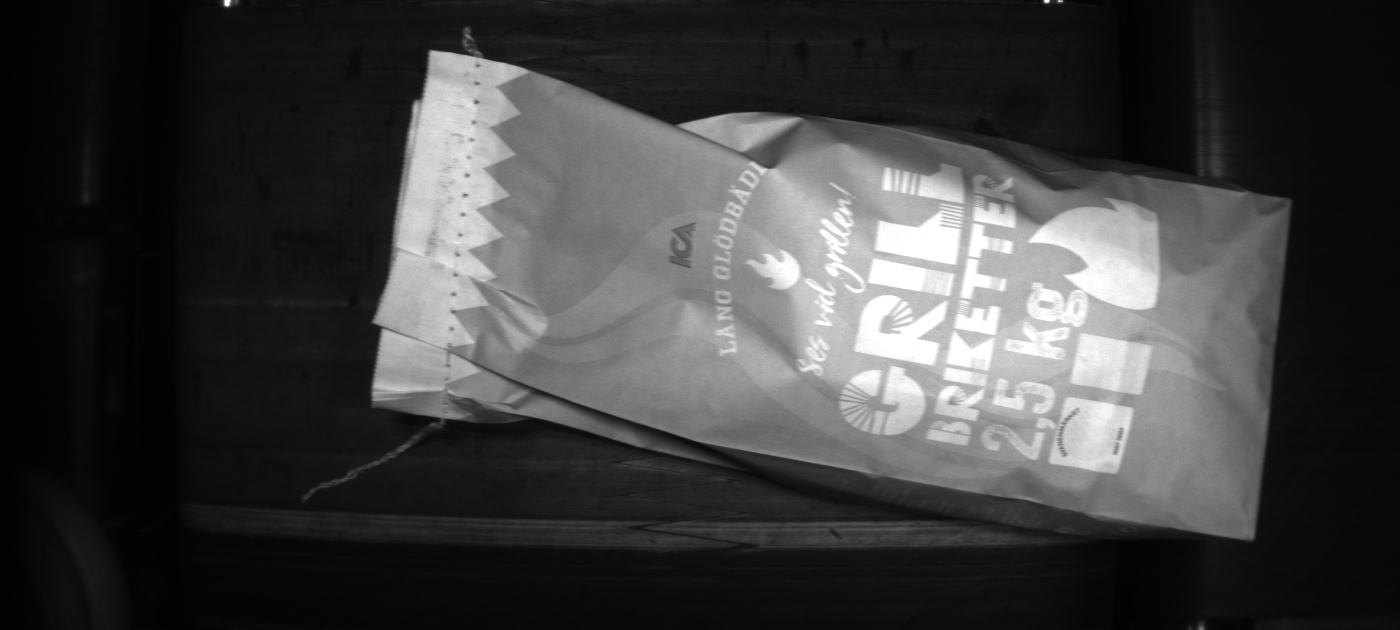

In [ ]:
OK= list( glob.glob(r'/content/drive/MyDrive/worki/OK/*.png'))
#NOK = list(glob.glob(r'/content/lemon-quality-dataset/lemon_dataset/bad_quality/*'))
PIL.Image.open(str(OK[2]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


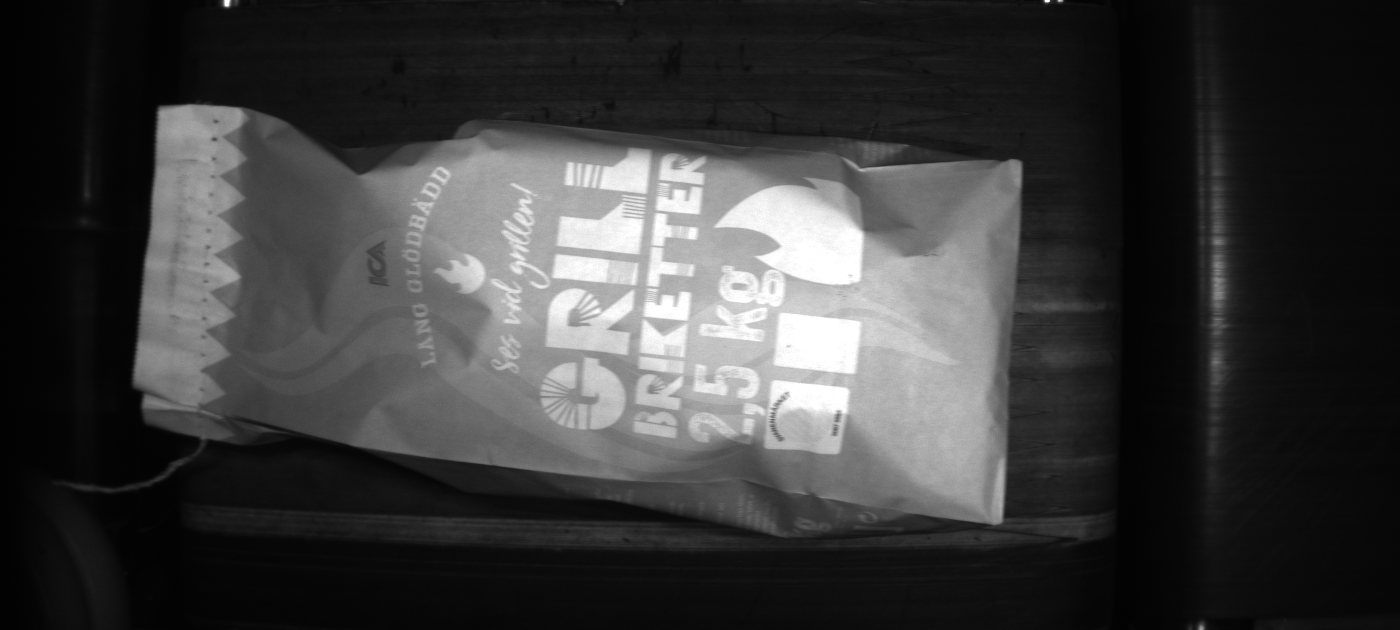

In [ ]:
NOK= list( glob.glob(r'/content/drive/MyDrive/worki/NOK/*.png'))

PIL.Image.open(str(NOK[0]))

We split the photo collection into photos for training and validation.It should be 80/20 
img_height and img_width is the size of the photos. The script reduces the size of the photo itself. It's worth having fun
these parameters. Too small a size will cause some information to disappear from the photo, too
the large size of the photo will cause the allocated memory to run out.
The batch_size variable tells about how many photos will be processed at once, it is about calculations
parallel run by the GPU. A low value will make learning time-consuming
long, high value can exhaust available resources.

In [ ]:
batch_size = 37
img_height = 180
img_width = 180



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/MyDrive/worki",
    validation_split = 0.20,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/worki",
    validation_split = 0.20,
    subset ="validation",
    seed = 123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 550 files belonging to 2 classes.
Using 440 files for training.
Found 550 files belonging to 2 classes.
Using 110 files for validation.


Define classes . In our case it should be only 2 folders OK and NOK .Nothing aditional 

In [ ]:
class_names =train_ds.class_names
print(class_names)

['NOK', 'OK']


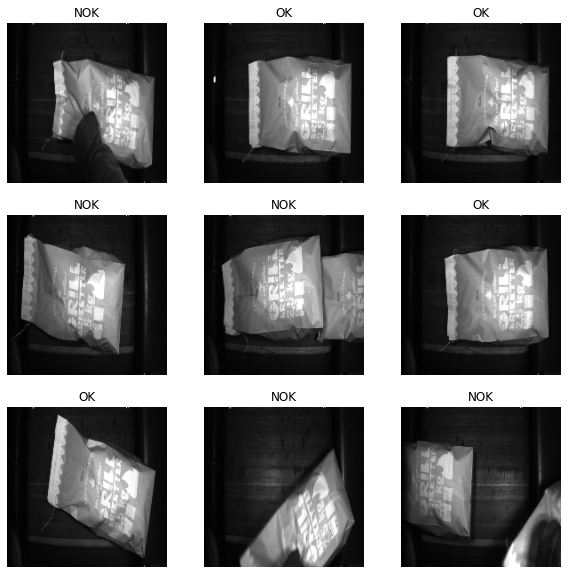

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Autotune.Parameters to increase the efficiency of network learning.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Defining what the neural network itself looks like, how many layers, how many neurons in a layer they have
neurons function.

conv2d layer https://keras.io/api/layers/convolution_layers/convolution2d/
MaxPool2d layer https://keras.io/api/layers/pooling_layers/max_pooling2d/
Dense layer https://keras.io/api/layers/core_layers/dense/

In [ ]:
num_classes = 2

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3) ),
                   # layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3) ),
                    layers.Conv2D(16,3,padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3,padding='same', activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3,padding='same', activation= 'relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding ='same', activation = 'relu'),
                    layers.Flatten(),
                    layers.Dense(512, activation='relu'),
                    layers.Dense(num_classes, activation='softmax')


])


Compile model .We use optimizer and losses method https://keras.io/api/models/model_training_apis/

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Launching the network learning  Epoch
tells how many learning iterations are to be performed. Generally it turns out that more is not better.

If you use cloud GPU it will be fast, but without it too long. But we can write network parameters during the train and continue train before . If you want to do it you should open Pojawas file and check how it looks there 

In [ ]:
epochs=45
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs,batch_size=batch_size)#, callbacks=[callbacks])  

Epoch 1/45
12/12 [==============================] - 10s 212ms/step - loss: 0.9104 - accuracy: 0.7432 - val_loss: 0.2363 - val_accuracy: 0.9364
Epoch 2/45
12/12 [==============================] - 0s 33ms/step - loss: 0.2041 - accuracy: 0.9364 - val_loss: 0.2278 - val_accuracy: 0.9364
Epoch 3/45
12/12 [==============================] - 0s 32ms/step - loss: 0.1593 - accuracy: 0.9523 - val_loss: 0.1462 - val_accuracy: 0.9818
Epoch 4/45
12/12 [==============================] - 0s 32ms/step - loss: 0.1063 - accuracy: 0.9705 - val_loss: 0.1504 - val_accuracy: 0.9455
Epoch 5/45
12/12 [==============================] - 0s 32ms/step - loss: 0.1395 - accuracy: 0.9545 - val_loss: 0.1186 - val_accuracy: 0.9545
Epoch 6/45
12/12 [==============================] - 0s 33ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.0674 - val_accuracy: 0.9909
Epoch 7/45
12/12 [==============================] - 0s 33ms/step - loss: 0.0567 - accuracy: 0.9841 - val_loss: 0.0656 - val_accuracy: 0.9818
Epoch 8/45


Key parameters after learning 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


We look on the chart on the left. You can see that the network has the training data
100% effectiveness and 98% on the validation data is a good result. You can also see that after
around 25 iterations, the network basically stopped learning.

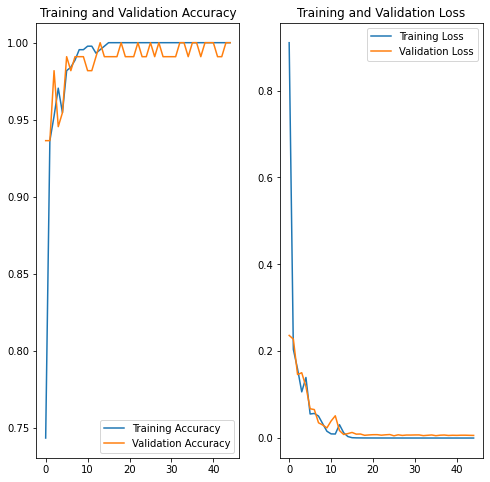

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Check our result on any img out of(not from ) ours dataset . The predictions variable determines result

1/1 [==============================] - 0s 21ms/step
[[8.1483573e-05 9.9991846e-01]]


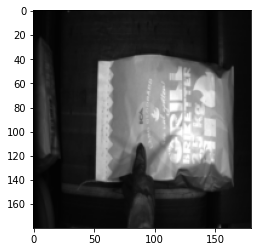

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/worki/Picture_2022_10_24__10_22_51_12.png", target_size=(img_height, img_width), interpolation="bilinear"
) 
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print(
#    "This image most likely belongs to {} with a {:.2f} percent confidence."
#    .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

print(predictions)

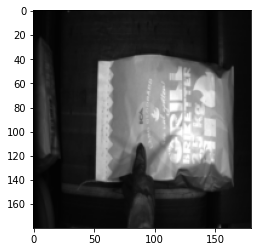

In [ ]:
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(img)

In [ ]:
print(predictions[0])
print(class_names)

[8.1483573e-05 9.9991846e-01]
['NOK', 'OK']


In [ ]:
os.chdir("/content/drive/MyDrive/My Drive/lastpr")

In [ ]:
os.getcwd()

'/content/drive/My Drive/lastpr'

Save our model . format .h5

In [ ]:
model.save('worki25_22.h5')

Load saved model

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/lastpr/worki25_22.h5")

Load img file and check prediction 

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/lastpr/lemon-quality-dataset/lemon_dataset/OK/good_quality_1000.jpg", target_size=(180, 180)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

That's all 